In [38]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pandas as pd
import numpy as np
import string
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import gc

In [39]:
## Initialize needed variables and set up pipelines for tokenizations

train = pd.read_pickle('D:/Stevens/Semester_academic/Semester 3/667/Competition_DataSolver/Result/Preprocessing_Train.pkl')
X_train, X_test, y_train, y_test = train_test_split(train.document_text, train.label, test_size=0.25)

stop_words = stopwords.words('english')
non_neg_stop = [i for i in stop_words if "n't" not in i and "no" not in i]
lemma = WordNetLemmatizer()


def pos(x):
    if x.startswith('J'):
        return 'a'
    elif x.startswith('V'):
        return 'v'
    elif x.startswith('R'):
        return 'r'
    else:
        return 'n'
    
    
def tok(doc, non_neg=False, lemmatized=False):
    
    if non_neg:
        stop = non_neg_stop
    else:
        stop = stop_words
       
    tokens = re.split(r'\s', doc.lower())
    
    if lemmatized:
        pos_list = nltk.pos_tag(tokens)
        tokens = list(map(lambda x: lemma.lemmatize(x[0], pos(x[1])), pos_list))    

    tokens = [i for i in tokens if i not in stop]
    tokens = [i for i in tokens if len(re.findall(r'\w', i)) >= 2]
    tokens = [re.findall(r"\w[a-zA-Z0-9.-]*\w", i)[0] for i in tokens if re.findall(r"\w[a-zA-Z0-9.-]*\w", i)]
    
    return tokens


def get_voc_new(X, non_neg=True, lemmatized=True):
    
    voc = []
    token_list = []
    for i in X:
        tokens = tok(i, non_neg, lemmatized)
        token_list.append(tokens)
        voc += tokens
        
    voc = list(set(voc))
    
    return voc, token_list

In [40]:
## tokenize train set and test set, create a vocabulary-index dictionary only based on train set

voc, tk_list_train = get_voc_new(X_train, False, True)
# voc, tk_list_train = get_voc_new(train.document_text, False, True)
voc_test, tk_list_test = get_voc_new(X_test, False, True)
voc_dic = {item: idx+1 for idx, item in enumerate(voc)}

In [41]:
## Convert tokens to index according to the dictionary we create in the last step 
## The unfound tokens would be padded with 0

def word2idx(token_list):
    
    token_idx = []
    for sent in token_list:
        sent_list = []
        for token in sent:
            if token in voc_dic:
                idx = voc_dic[token]
            else:
                idx = 0
            sent_list.append(idx)
        token_idx.append(sent_list)

    return token_idx


tk_idx_train = word2idx(tk_list_train)
tk_idx_test = word2idx(tk_list_test)

In [42]:
## Create a Pytorch Dataset class to convert data to tensors
## Each token index list is set to the same length, 1024 by default
## The shorter one would be padded with 0, and the longer one would be truncated

class dataset_(Dataset):
    
    def __init__(self, X, y, max_len=1024):
        super(dataset_, self).__init__()
        pad = [i[:max_len] + [0]*(max_len-len(i[:max_len])) for i in X]
        self.X = torch.tensor(pad, dtype=torch.int32)
        self.y = torch.Tensor(np.array(list(y)))
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
train_ = dataset_(tk_idx_train, y_train)
# train_ = dataset_(tk_idx_train, train.label)
test_ = dataset_(tk_idx_test, y_test)

In [57]:
# class PE(nn.Module): 

#     def __init__(self, dim_emb=256, dropout=0.5, max_len=1024): 
#         super(PE, self).__init__() 
#         self.dropout = nn.Dropout(dropout) 
#         pe = torch.zeros(max_len, dim_emb) 
#         position = torch.arange(0, max_len).unsqueeze(1) 
#         div_term = torch.exp(-math.log(10000) * torch.arange(0, dim_emb, 2)/dim_emb)
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term) 
#         pe = pe.unsqueeze(0) 
#         self.register_buffer('pe', pe) 
        
#     def forward(self, x): 
#         x = x + Variable(self.pe[:, :], requires_grad=False) 
#         return self.dropout(x) 

    
# class MultAtt(nn.Module):
    
#     def __init__(self, dim_emb=256):
#         super(Att, self).__init__()
#         self.Wq = nn.Linear(dim_emb, dim_emb, bias=False)
#         self.Wk = nn.Linear(dim_emb, dim_emb, bias=False)
#         self.Wv = nn.Linear(dim_emb, dim_emb, bias=False)
#         self.Wo = nn.Linear(dim_emb, 50, bias=False)

#     def forward(self, x):
#         Q = self.Wq(x)
#         K = self.Wk(x)
#         V = self.Wv(x)
#         interval = int(K.size(-1)/4)
#         Z = torch.cat([torch.matmul(nn.Softmax(dim=-1)(torch.matmul(
#                 Q[:,:, i:i+interval], K[:,:, i:i+interval].transpose(-2, -1))
#                 /math.sqrt(interval)), V[:,:, i:i+interval]) 
#                 for i in range(0, K.size(-1), interval)], dim=-1)
#         return self.Wo(Z).transpose(-2, -1)


class Emb(nn.Module):
    
    def __init__(self, voc_size, dim_emb):
        super(Emb, self).__init__()
        self.emb = nn.Sequential(
            nn.Embedding(voc_size, dim_emb, padding_idx=0),
            nn.Linear(dim_emb, 256),
            nn.ReLU())

    def forward(self, x):
        return self.emb(x)

    
class Conv(nn.Module):
    
    def __init__(self, dim_emb, dim_out):
        super(Conv, self).__init__()
        self.cv1 = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, 1),
            nn.BatchNorm1d(dim_out),
            nn.ReLU(),
            nn.MaxPool1d(3, 2))
        self.cv2 = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, 2),
            nn.BatchNorm1d(dim_out),
            nn.ReLU(),
            nn.MaxPool1d(3, 2)) 
        self.cv3 = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, 3),
            nn.BatchNorm1d(dim_out),
            nn.ReLU(),
            nn.MaxPool1d(2, 2))

    def forward(self, x):
        C1 = self.cv1(x.transpose(-2, -1)).transpose(-2, -1)
        C2 = self.cv2(x.transpose(-2, -1)).transpose(-2, -1)
        C3 = self.cv3(x.transpose(-2, -1)).transpose(-2, -1)
        return torch.cat([C1,C2,C3], dim=-1)
    
    
class EndConv(nn.Module):
    
    def __init__(self, dim_emb, dim_out, conv_size):
        super(EndConv, self).__init__()
        self.ecv = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, conv_size),
            nn.BatchNorm1d(dim_out),
            nn.ReLU())

    def forward(self, x):
        Z = self.ecv(x.transpose(-2, -1))
        return nn.MaxPool1d(Z.size(-1))(Z).squeeze(-1)

    
# class SelfAtt(nn.Module):
    
#     def __init__(self, dim_emb=256, dim_enc=256):
#         super(SelfAtt, self).__init__()
#         self.Wq = nn.Linear(dim_emb, dim_enc, bias=False)
#         self.Wk = nn.Linear(dim_emb, dim_enc, bias=False)
#         self.Wv = nn.Linear(dim_emb, dim_enc, bias=False)

#     def forward(self, x):
#         Q = self.Wq(x)
#         K = self.Wk(x)
#         V = self.Wv(x)
#         score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(K.size(-1)) ## (50, 1200)
#         return torch.matmul(nn.Softmax(dim=-1)(score), V)
    
            
class Att(nn.Module):
    
    def __init__(self, dim_emb=256, dim_enc=128):
        super(Att, self).__init__()
        self.Wq = nn.Linear(dim_emb, dim_enc, bias=False)
        self.Wk = nn.Linear(dim_emb, dim_emb, bias=False)
        self.Wv = nn.Linear(dim_emb, dim_emb, bias=False)

    def forward(self, x):
        K = self.Wk(x)
        V = self.Wv(x)
        temp = self.Wq(K) 
        score = temp.transpose(-2, -1) / math.sqrt(K.size(-1)) ## (50, 1200)
        return torch.matmul(nn.Softmax(dim=-1)(score), V)
    
    
class LN(nn.Module):
    
    def __init__(self, dim_emb=256):
        super(LN, self).__init__()
        self.feed = nn.LayerNorm(dim_emb)

    def forward(self, x):
        return x + self.feed(x)


class final_model(nn.Module):
    
    def __init__(self, voc_size=len(voc)+1, dim_emb=256, dropout=0.5, max_len=1024):
        super(final_model, self).__init__()
        self.net = nn.Sequential(
            Emb(voc_size, dim_emb),  ## (1024, dim_emb)
            Conv(dim_emb, 256),
            nn.Dropout(dropout),
            Att(768, 50),
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid())
            
    def forward(self, x):
        return self.net(x)

In [58]:
def train_model(model, train_dataset, eval_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'eval_loss': [], 'detail_train': [], 'detail_eval': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

    model = model.to(device)
    save_loss = nn.BCELoss(reduction='none').to(device)
    
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)

    else:
        Loss = nn.BCELoss().to(device)
        
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        eval_loss = 0
        detail_train = torch.zeros(50).to(device)
        detail_eval = torch.zeros(50).to(device)
        pred = []
        real = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X).squeeze(-1)
            loss = Loss(out, y)
            save_train = save_loss(out, y).sum(0)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            detail_train += save_train
            
        model.eval()
        with torch.no_grad():
            for X, y in eval_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X).squeeze(-1)
                loss = Loss(out, y)
                save_eval = save_loss(out, y).sum(0)
                detail_eval += save_eval
                eval_loss += loss
                pred.append(out.cpu())
                real.append(y.cpu())
                
        train_loss = (train_loss/len(train_loader)).item()
        eval_loss = (eval_loss/len(eval_loader)).item() 
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)  
        history['detail_train'].append(detail_train.cpu().detach())
        history['detail_eval'].append(detail_eval.cpu().detach())  
        
        if not (epoch+1)%10:
            print(f"epoch {epoch+1}\ntrain loss: {train_loss}\t\teval loss: {eval_loss}")
        
        if not (epoch+1)%50:
            res = torch.cat(pred)
            tru = torch.cat(real)
            print(f'\nepoch {epoch+1}:\n')
            print(f"f1_score for 50 classes: {f1_score(tru, np.round(res), average='macro')}")
            print(classification_report(tru, np.round(res)))
            print(f'\nSpent time: {time.time()-start} seconds')
            
        
    print('Training complete!')
    
    return history

In [59]:
torch.cuda.empty_cache()
gc.collect()

3806

Training start!
epoch 10
train loss: 0.2387036830186844		eval loss: 0.23205509781837463
epoch 20
train loss: 0.15070392191410065		eval loss: 0.15272749960422516
epoch 30
train loss: 0.10736442357301712		eval loss: 0.12714196741580963
epoch 40
train loss: 0.08185892552137375		eval loss: 0.1246989518404007
epoch 50
train loss: 0.06472375988960266		eval loss: 0.12580625712871552

epoch 50:

f1_score for 50 classes: 0.7798970055958538
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       215
           1       0.81      0.80      0.80       208
           2       0.87      0.86      0.86       255
           3       0.90      0.77      0.83       200
           4       0.86      0.94      0.90       171
           5       0.88      0.94      0.91       360
           6       0.89      0.86      0.87       248
           7       0.78      0.82      0.80       285
           8       0.77      0.46      0.58       128
           9       0.60 

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 60
train loss: 0.053545087575912476		eval loss: 0.13724371790885925
epoch 70
train loss: 0.043245829641819		eval loss: 0.15043507516384125
epoch 80
train loss: 0.03669610992074013		eval loss: 0.1499050408601761
epoch 90
train loss: 0.030698789283633232		eval loss: 0.15864543616771698
epoch 100
train loss: 0.026505613699555397		eval loss: 0.16760171949863434

epoch 100:

f1_score for 50 classes: 0.7974522554128746
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       215
           1       0.80      0.83      0.82       208
           2       0.91      0.86      0.88       255
           3       0.89      0.83      0.86       200
           4       0.85      0.91      0.88       171
           5       0.88      0.94      0.91       360
           6       0.94      0.87      0.90       248
           7       0.83      0.80      0.81       285
           8       0.68      0.58      0.62       128
           9       0.67      0.59   

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 110
train loss: 0.024284882470965385		eval loss: 0.1623009890317917
epoch 120
train loss: 0.022168483585119247		eval loss: 0.18639473617076874
epoch 130
train loss: 0.018245453014969826		eval loss: 0.20770154893398285
epoch 140
train loss: 0.01770789921283722		eval loss: 0.19166992604732513
epoch 150
train loss: 0.016199849545955658		eval loss: 0.21389655768871307

epoch 150:

f1_score for 50 classes: 0.8000486338035223
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       215
           1       0.89      0.81      0.85       208
           2       0.91      0.84      0.88       255
           3       0.92      0.82      0.87       200
           4       0.89      0.90      0.90       171
           5       0.89      0.92      0.90       360
           6       0.96      0.86      0.91       248
           7       0.84      0.77      0.80       285
           8       0.85      0.53      0.65       128
           9       0.81      

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 160
train loss: 0.013926589861512184		eval loss: 0.21660366654396057
epoch 170
train loss: 0.012624039314687252		eval loss: 0.2681832015514374
epoch 180
train loss: 0.011796997860074043		eval loss: 0.2241203635931015
epoch 190
train loss: 0.011178610846400261		eval loss: 0.22798240184783936
epoch 200
train loss: 0.010977676138281822		eval loss: 0.21529622375965118

epoch 200:

f1_score for 50 classes: 0.8028228993075582
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       215
           1       0.85      0.85      0.85       208
           2       0.95      0.85      0.90       255
           3       0.92      0.83      0.87       200
           4       0.89      0.92      0.90       171
           5       0.89      0.92      0.90       360
           6       0.95      0.87      0.91       248
           7       0.81      0.81      0.81       285
           8       0.80      0.54      0.64       128
           9       0.67      

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


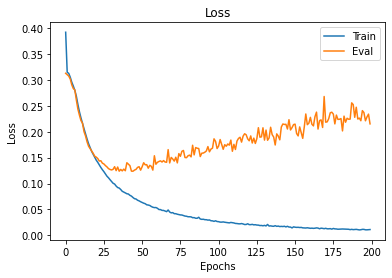

In [56]:
## Conv 128*3
mod = final_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
lr = 3e-4
batch_size = 128
norm = None

hist = train_model(mod, train_, test_, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

Training start!
epoch 10
train loss: 0.20114921033382416		eval loss: 0.19632606208324432
epoch 20
train loss: 0.12151434272527695		eval loss: 0.1345425248146057
epoch 30
train loss: 0.08020966500043869		eval loss: 0.12221838533878326
epoch 40
train loss: 0.05537307634949684		eval loss: 0.1343243569135666
epoch 50
train loss: 0.039809733629226685		eval loss: 0.15481601655483246

epoch 50:

f1_score for 50 classes: 0.7933256299794784
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       215
           1       0.85      0.73      0.79       208
           2       0.88      0.87      0.87       255
           3       0.87      0.89      0.88       200
           4       0.84      0.90      0.87       171
           5       0.86      0.94      0.90       360
           6       0.90      0.86      0.88       248
           7       0.78      0.85      0.81       285
           8       0.77      0.52      0.62       128
           9       0.71

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 60
train loss: 0.02913506142795086		eval loss: 0.1693870723247528
epoch 70
train loss: 0.02375415712594986		eval loss: 0.1747894138097763
epoch 80
train loss: 0.01878267340362072		eval loss: 0.18076148629188538
epoch 90
train loss: 0.016096550971269608		eval loss: 0.20292353630065918
epoch 100
train loss: 0.013550454750657082		eval loss: 0.21781770884990692

epoch 100:

f1_score for 50 classes: 0.8049960224146996
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       215
           1       0.86      0.80      0.83       208
           2       0.87      0.88      0.88       255
           3       0.90      0.86      0.88       200
           4       0.86      0.90      0.88       171
           5       0.87      0.92      0.89       360
           6       0.94      0.83      0.88       248
           7       0.80      0.85      0.82       285
           8       0.68      0.58      0.62       128
           9       0.75      0.59   

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 110
train loss: 0.011040562763810158		eval loss: 0.22813069820404053
epoch 120
train loss: 0.01041000708937645		eval loss: 0.20531435310840607
epoch 130
train loss: 0.00909955333918333		eval loss: 0.2362905591726303
epoch 140
train loss: 0.007770299445837736		eval loss: 0.22582726180553436
epoch 150
train loss: 0.007602329831570387		eval loss: 0.23019294440746307

epoch 150:

f1_score for 50 classes: 0.8098347695440359
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       215
           1       0.90      0.79      0.84       208
           2       0.91      0.87      0.89       255
           3       0.90      0.84      0.87       200
           4       0.86      0.89      0.88       171
           5       0.89      0.91      0.90       360
           6       0.92      0.86      0.89       248
           7       0.84      0.84      0.84       285
           8       0.82      0.54      0.65       128
           9       0.73      0

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 160
train loss: 0.006753028370440006		eval loss: 0.24954204261302948
epoch 170
train loss: 0.006507575511932373		eval loss: 0.2113114595413208
epoch 180
train loss: 0.005612178239971399		eval loss: 0.26581400632858276
epoch 190
train loss: 0.005177581682801247		eval loss: 0.2603191137313843
epoch 200
train loss: 0.005007042083889246		eval loss: 0.27637624740600586

epoch 200:

f1_score for 50 classes: 0.8112029914302867
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       215
           1       0.88      0.80      0.84       208
           2       0.88      0.87      0.88       255
           3       0.91      0.89      0.90       200
           4       0.85      0.89      0.87       171
           5       0.89      0.91      0.90       360
           6       0.91      0.85      0.88       248
           7       0.87      0.81      0.84       285
           8       0.82      0.55      0.66       128
           9       0.74      

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 210
train loss: 0.004719207528978586		eval loss: 0.27748867869377136
epoch 220
train loss: 0.004476815462112427		eval loss: 0.33619531989097595
epoch 230
train loss: 0.0043535069562494755		eval loss: 0.2798103094100952
epoch 240
train loss: 0.003994444385170937		eval loss: 0.3282116651535034
epoch 250
train loss: 0.0038168542087078094		eval loss: 0.4212845265865326

epoch 250:

f1_score for 50 classes: 0.8063143979317551
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       215
           1       0.88      0.82      0.85       208
           2       0.84      0.87      0.85       255
           3       0.90      0.85      0.87       200
           4       0.84      0.91      0.87       171
           5       0.88      0.94      0.91       360
           6       0.92      0.85      0.88       248
           7       0.81      0.85      0.83       285
           8       0.73      0.57      0.64       128
           9       0.74     

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


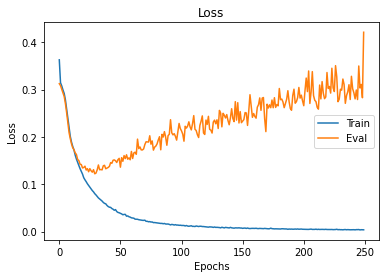

In [60]:
## Conv 256*3
mod = final_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 250
lr = 3e-4
batch_size = 128
norm = None

hist = train_model(mod, train_, test_, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

## Test

In [123]:
voc, tk_list_train = get_voc_new(train.document_text, False, True)
voc_dic = {item: idx+1 for idx, item in enumerate(voc)}

def word2idx(token_list):
    
    token_idx = []
    for sent in token_list:
        sent_list = []
        for token in sent:
            if token in voc_dic:
                idx = voc_dic[token]
            else:
                idx = 0
            sent_list.append(idx)
        token_idx.append(sent_list)

    return token_idx

class dataset_(Dataset):
    
    def __init__(self, X, y, max_len=1024):
        super(dataset_, self).__init__()
        pad = [i[:max_len] + [0]*(max_len-len(i[:max_len])) for i in X]
        self.X = torch.tensor(pad, dtype=torch.int32)
        self.y = torch.Tensor(np.array(list(y)))
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)


tk_idx_train = word2idx(tk_list_train)
train_ = dataset_(tk_idx_train, train.label)

In [130]:
class Emb(nn.Module):
    
    def __init__(self, voc_size, dim_emb):
        super(Emb, self).__init__()
        self.emb = nn.Sequential(
            nn.Embedding(voc_size, dim_emb, padding_idx=0),
            nn.Linear(dim_emb, 256),
            nn.ReLU())

    def forward(self, x):
        return self.emb(x)

    
class Conv(nn.Module):
    
    def __init__(self, dim_emb, dim_out, conv_size, pool_size, pool_stride=None):
        super(Conv, self).__init__()
        self.cv = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, conv_size),
            nn.BatchNorm1d(dim_out),
            nn.ReLU(),
            nn.MaxPool1d(pool_size, pool_stride))

    def forward(self, x):
        return self.cv(x.transpose(-2, -1)).transpose(-2, -1)
    
    
class EndConv(nn.Module):
    
    def __init__(self, dim_emb, dim_out, conv_size):
        super(EndConv, self).__init__()
        self.ecv = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, conv_size),
            nn.BatchNorm1d(dim_out),
            nn.ReLU())

    def forward(self, x):
        Z = self.ecv(x.transpose(-2, -1))
        return nn.MaxPool1d(Z.size(-1))(Z).squeeze(-1)

            
class Att(nn.Module):
    
    def __init__(self, dim_emb=256, dim_enc=128):
        super(Att, self).__init__()
        self.Wq = nn.Linear(dim_emb, dim_enc, bias=False)
        self.Wk = nn.Linear(dim_emb, dim_emb, bias=False)
        self.Wv = nn.Linear(dim_emb, dim_emb, bias=False)

    def forward(self, x):
        K = self.Wk(x)
        V = self.Wv(x)
        temp = self.Wq(K) 
        score = temp.transpose(-2, -1) / math.sqrt(K.size(-1)) ## (50, 1200)
        return torch.matmul(nn.Softmax(dim=-1)(score), V)
    
    
class LN(nn.Module):
    
    def __init__(self, dim_emb=256):
        super(LN, self).__init__()
        self.feed = nn.LayerNorm(dim_emb)

    def forward(self, x):
        return x + self.feed(x)


class final_model(nn.Module):
    
    def __init__(self, voc_size=len(voc)+1, dim_emb=256, dropout=0.5, max_len=1024):
        super(final_model, self).__init__()
        self.net = nn.Sequential(
            Emb(voc_size, dim_emb),  ## (1024, dim_emb)
            Conv(dim_emb, 256, 3, 3, 2),
            # Conv(256, 256, 2, 3, 2),
            # Conv(128, 128, 1, 3, 2),
            # EndConv(128, 64, 1),
            nn.Dropout(dropout),
            Att(256, 50),
#             # Att(256, 50),
#             nn.Linear(256, 256),
#             # LN(dim_emb),
#             nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid())
            
    def forward(self, x):
        return self.net(x)

In [131]:
def train_test(model, train_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = model.to(device)
    
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)

    else:
        Loss = nn.BCELoss().to(device)
        
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X).squeeze(-1)
            loss = Loss(out, y)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
        
        if not (epoch+1)%10:
            print(f"epoch {epoch+1}")
            print(f"train loss: {train_loss}")
            print(f'Spent time: {time.time()-start} seconds')              
        
    print('Training complete!')

    return None

In [132]:
mod = final_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
lr = 3e-4
batch_size = 128
norm = None

train_test(mod, train_, device, norm, lr=lr, epochs=epochs, batch_size=batch_size)

Training start!
epoch 10
train loss: 17.62736701965332
Spent time: 43.57790517807007 seconds
epoch 20
train loss: 11.519508361816406
Spent time: 87.06126952171326 seconds
epoch 30
train loss: 8.530522346496582
Spent time: 130.70476913452148 seconds
epoch 40
train loss: 6.779897212982178
Spent time: 174.37212991714478 seconds
epoch 50
train loss: 5.523341655731201
Spent time: 218.0446321964264 seconds
epoch 60
train loss: 4.641663074493408
Spent time: 262.6173746585846 seconds
epoch 70
train loss: 3.9686288833618164
Spent time: 306.1678283214569 seconds
epoch 80
train loss: 3.381434440612793
Spent time: 350.4514436721802 seconds
epoch 90
train loss: 3.1918463706970215
Spent time: 393.9771194458008 seconds
epoch 100
train loss: 2.925536632537842
Spent time: 437.53164982795715 seconds
epoch 110
train loss: 2.312613010406494
Spent time: 481.10934710502625 seconds
epoch 120
train loss: 1.997349739074707
Spent time: 524.629825592041 seconds
epoch 130
train loss: 1.8232377767562866
Spent time

In [133]:
test = pd.read_csv('datasolve-us/test.csv')
voc_test, tk_list_test = get_voc_new(test.document_text, False, True)
tk_idx_test = word2idx(tk_list_test)
pad_test = [i[:1024] + [0]*(1024-len(i[:1024])) for i in tk_idx_test]
test_ = torch.tensor(pad_test, dtype=torch.int32)

In [134]:
test_ = test_.to(device)
mod = mod.to(device)
res = []
with torch.no_grad():
    for i in DataLoader(test_, batch_size=256, shuffle=False):
        res.append(mod(i).cpu())

In [135]:
fin = torch.cat(res, dim=0).squeeze(-1)

fin = np.round(fin.view(-1))

In [136]:
pd.DataFrame(fin, columns=['predictions']).to_csv('cnn_att_3.csv')